In [120]:
import os
os.chdir('C:\\Users\\PMLS\\OneDrive\\Desktop')
#paste the location of the Imagedata here
'''-----------------------------------------------------------------------------------------------------------------------'''
import zipfile
import os
#Path to the uploaded zip file
zip_file_path = 'Imagedata.zip'
#Directory where you want to extract the files
extraction_directory = 'Imagedata'
#Creating the directory if it doesn't exist
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)
#Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)
print("Extraction completed.")

Extraction completed.


In [134]:
from PIL import Image
import os
#Base directory
base_dir = os.path.join('Imagedata', 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', 
                        'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')
#Categories
categories = ['Tumor', 'Stone', 'Normal', 'Cyst']
#Dictionary to hold image data
images = {category: [] for category in categories}
#Loading images
for category in categories:
    category_path = os.path.join(base_dir, category)
    for img_file in os.listdir(category_path):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(category_path, img_file)
            with Image.open(img_path) as img:
                images[category].append(img.copy())
print("Images loaded successfully.")

Images loaded successfully.


In [135]:
#DATA PROCESSING (RESIZING THE IMAGES)
from PIL import Image
import os
#Target size for resizing
target_size = (256, 256)
#Categories
categories = ['Tumor', 'Stone', 'Normal', 'Cyst']
#Dictionary to hold image data
resized_images = {category: [] for category in categories}
#Resizing images
for category in categories:
    category_path = os.path.join(base_dir, category)
    for img_file in os.listdir(category_path):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(category_path, img_file)
            with Image.open(img_path) as img:
                # Resize image
                img_resized = img.resize(target_size)
                resized_images[category].append(img_resized)
print("Images resized successfully.")

Images resized successfully.


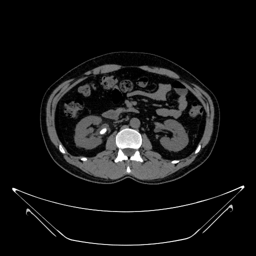

In [136]:
from IPython.display import display
#Selecting a category
category = 'Stone'
if resized_images[category]:
    image_to_show = resized_images[category][5]
    display(image_to_show)
else:
    print(f"No images found in the category '{category}'.")
save_path = 'C:\\Users\\PMLS\\OneDrive\\Desktop' # Replace this with your desired path
    
    # Save the image to the specified path
image_to_show.save(os.path.join(save_path, f"{category}_image1.jpg"))

Image enhancement completed.


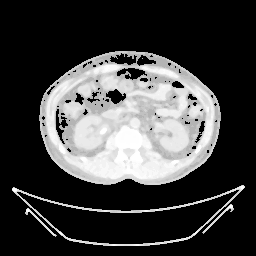

In [124]:
#IMAGE ENHANCEMENT 
from PIL import ImageEnhance, ImageFilter, ImageOps
#Function for adjusting contrast
def adjust_contrast(image, factor=0.2):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)
#Function for applying a mild denoise effect
def apply_mild_denoise(image):
    return image.filter(ImageFilter.MedianFilter(size=3))
#Function for histogram equalization
def equalize_histogram(image):
    return ImageOps.equalize(image.convert('L'))
#Enhancing images: adjusting contrast, denoising, and equalizing histograms
enhanced_images = {category: [] for category in resized_images.keys()}
for category, img_list in resized_images.items():
    for img in img_list:
        img_contrast = adjust_contrast(img)
        img_denoised = apply_mild_denoise(img_contrast)
        img_equalized = equalize_histogram(img_denoised)
        enhanced_images[category].append(img_equalized)
print("Image enhancement completed.")

from IPython.display import display
#Selecting a category
category = 'Stone'  # or choose 'Stone', 'Normal', 'Cyst'
#Selecting the first image in the chosen category
if enhanced_images[category]:
    image_to_show = enhanced_images[category][5]
    display(image_to_show)
else:
    print(f"No images found in the category '{category}'.")

Image segmentation completed.


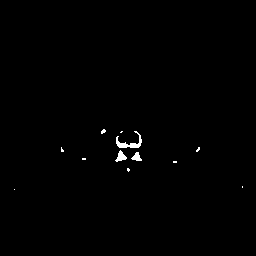

In [137]:
#IMAGE SEGMENTATION
from PIL import ImageOps
def segment_image(image, threshold=255):
    # Convert image to grayscale
    gray_image = image.convert('L')
    # Applying threshold
    return gray_image.point(lambda x: 0 if x < threshold else 255, '1')
#Segmented images
segmented_images = {category: [] for category in enhanced_images.keys()}
for category, img_list in enhanced_images.items():
    for img in img_list:
        segmented_img = segment_image(img)
        segmented_images[category].append(segmented_img)
print("Image segmentation completed.")
from IPython.display import display
#Selecting a category
category = 'Stone'
#Selecting the first image in the chosen category
if segmented_images[category]:
    image_to_show = segmented_images[category][5]
    display(image_to_show)
else:
    print(f"No images found in the category '{category}'.")

Binary masks created.


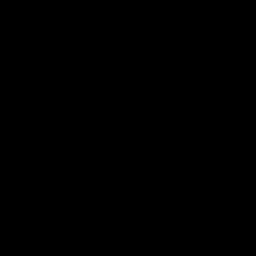

In [143]:
from PIL import ImageDraw
binary_masks = {category: [] for category in segmented_images.keys()}
exclude_coordinates = [(114, 129), (148, 128), (113, 195), (142, 195)]  
# Define a function to exclude coordinates from the binary mask
def exclude_rectangular_areas_from_mask(mask, coordinates):
    width, height = mask.size
    for i in range(len(coordinates) - 1):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[i + 1]
        # Ensure coordinates are within image boundaries
        x1 = max(0, min(x1, width))
        y1 = max(0, min(y1, height))
        x2 = max(0, min(x2, width))
        y2 = max(0, min(y2, height))
        # Fill the area between the points with black (0)
        for y in range(min(y1, y2), max(y1, y2)):
            for x in range(min(x1, x2), max(x1, x2)):
                mask.putpixel((x, y), 0)  # Set pixel to black (0)

# Iterate over segmented images and create binary masks
for category, img_list in segmented_images.items():
    for img in img_list:
        # Adjust the threshold to set pixels less than 230 to white and others to black
        binary_mask = img.point(lambda x: 255 if x > 230 else 0, '1')
        
        # Exclude specified rectangular areas from the binary mask
        exclude_rectangular_areas_from_mask(binary_mask, exclude_coordinates)
        
        binary_masks[category].append(binary_mask)

print("Binary masks created.")

from IPython.display import display
#Selecting a category
category = 'Stone'
if binary_masks[category]:
    mask_to_show = binary_masks[category][5]
    display(mask_to_show)
else:
    print(f"No masks found in the category '{category}'.")

In [139]:

#COLORING SEGMENTED AREAS
from PIL import Image
def add_colored_mask(original_img, mask, color=(255, 0, 0), transparency=0.5):
    # Create a colored overlay
    colored_mask = Image.new("RGBA", original_img.size, color)
    #Apply the binary mask to the colored overlay
    masked_overlay = Image.composite(colored_mask, Image.new("RGBA", original_img.size), mask.convert("L"))
    #Reduce the transparency of the overlay
    masked_overlay.putalpha(int(255 * transparency))
    #Combine the original image with the overlay
    combined_img = Image.alpha_composite(original_img.convert("RGBA"), masked_overlay)
    return combined_img.convert("RGB")
#Use the enhanced images as the base for overlay
source_images = resized_images  # or use resized_images if you prefer
colored_images = {category: [] for category in source_images.keys()}
for category, img_list in source_images.items():
    for img, mask in zip(img_list, binary_masks[category]):
        colored_img = add_colored_mask(img, mask)
        colored_images[category].append(colored_img)
print("Color added to segmented areas.")

Color added to segmented areas.


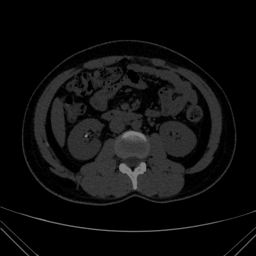

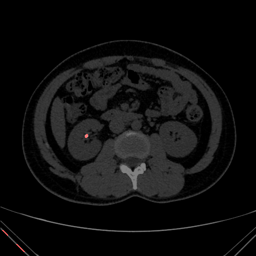

In [142]:
from IPython.display import display

#Selecting a category
category = 'Stone'
#Selecting the first colored image in the chosen category
if colored_images[category]:
    colored_image_to_show = colored_images[category][5]
    display(colored_image_to_show)
    colored_image_to_show = colored_images[category][3]
    display(colored_image_to_show)
else:
    print(f"No colored images found in the category '{category}'.")